## Introduction

This text is mainly based on the article "A Comparative Predicting Stock Prices using Heston and Geometric Brownian Motion Models" (https://arxiv.org/abs/2302.07796), and on the material available at (https://github.com/TheQuantPy).

Heston Model is a stochastic volatility model, i.e., a model who assumes that, different then models like Black-Scholes that states volatility as a constant in time evolution, volatility of an asset, on Heston Model, isn't constant and is also a stochastic process. That assumption makes stochastic volatility models capture some market features like volatility mean reversion and volatility smiles.

Not only there are other stochastic volatility models rather then Heston model, like SABR, GARCH, Chen, 3/2, CEV, etc, but there are also evolutions of Heston Model, like Jump-Diffusion Heston Model, Fractional Heston Model and Multi-Factor Heston Model.

Here, we are going to implement Heston model, for pricing options for dividend paying stocks, using Monte Carlo Simulations and confront its results with Geometric Brownian Motion (GBM). And, at the end, we will see that, in contrast with Black-Scholes model, Heston Model can capture volatility smiles. 

Heston model for a is described by a set of three equations, given by:

$$ dS_t = \mu S_t dt + \sqrt{V_t}S_t dW^1_t,
$$
$$ dV_t = \kappa(\theta - V_t)dt + \sigma\sqrt{V_t}dW^2_t,
$$
$$ dW^1_t \cdot dW^2_t = \rho dt.
$$

It's important to remember that these expressions are described using _Real World Measure_, so to speak, in computational applications, there will be needed the use of _Girsanov's Theorem_ to give us a way for simple discription of our two stochastic process during Monte Carlo Simulations.

In contrast with Heston Model, the equation that gives the Geometrical Brownian Motion is:
$$dS_t = \mu S_t dt + \sigma S_t dW_t,
$$

and here we can see that Heston model is an extension of Black-Scholes model, which don't assumes that volatility is constant over time, but intead, a stochastic process as well.

## Importing Libraries

In [55]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skopt import gp_minimize as gpm

import warnings
warnings.filterwarnings("ignore")
np.random.seed(1)

## Monte Carlo Simulation of the Heston Model

To do computation using Heston Model's equations, we need to discretise these expressions. So the way we will do this is by using Euler discretisation method of SDE's (https://frouah.com/finance%20notes/Euler%20and%20Milstein%20Discretization.pdf).

$$ dS_{i+1} = S_i e^{(r-q-\frac{v_i}{2})\Delta t+\sqrt{v_i}\Delta t W^{\mathbb{Q}}_{S, i+1}}
$$
$$ v_{i+1} = v_i + \kappa^{\mathbb{Q}}(\theta^{\mathbb{Q}}-v_i)\Delta t + \sigma^{\mathbb{Q}} \sqrt{v_i}\Delta t W^{\mathbb{Q}}_{v, i+1}
$$

Here, we have done two things, not only we have discretised the SDE's above, but also changed the measure used. Here, in risk-neutral measure $\mathbb{Q}$, some things will be changed but others don't. The correlation coefficient remais the same, $\rho=\rho^{\mathbb{Q}}$, and also volatility of volatility, $\sigma=\sigma^{\mathbb{Q}}$,

In [91]:
class HestonModelSim():
    def __init__(self, S0, v0, rho, kappa, theta, sigma, T, N, M, r, q = 0):
        self.S0 = S0                                                            # The start price of the asset
        self.v0 = v0                                                            # Initial value of the volatility under risk neutral measure
        self.rho = rho                                                          # Correlation between the series of returns and volatility using risk neutral measure
        self.kappa = kappa                                                      # Mean reversion rate of volatility at risk neutral measure
        self.theta = theta                                                      # Long term mean of variance under risk neutral measure
        self.sigma = sigma                                                      # Volatility of volatility (Vol o Vol)
        self.T = T                                                              # Time in Years
        self.N = N                                                              # Number of time steps in each simulation
        self.M = M                                                              # Number of simulations
        self.r = r                                                              # Risk-free interest rate
        self.q = q                                                              # Dividend Yield
        
        self.dt = self.T/self.N                                                 # Time increment in each step within the simulation
        self.mu = np.array([0, 0])                                              # An imposition of a mean value for the random distrbution
        self.cov = np.array([[1, self.rho],[self.rho, 1]])                      # An imposition of a Covariance Matrix for the random distrbution

        self.S = np.full(shape=(self.N+1, self.M), fill_value=self.S0)
        self.V = np.full(shape=(self.N+1, self.M), fill_value=self.v0)

        self.S_mean = np.full(shape=(self.N+1, 1), fill_value=self.S0)
        self.V_mean = np.full(shape=(self.N+1, 1), fill_value=self.v0)

        self.Z = np.random.multivariate_normal(self.mu, self.cov, (self.N, self.M))
    
        self.K = np.arange(20,180,2)

    def run(self):
        for i in range(1, self.N+1):
            self.S[i] = self.S[i-1] * np.exp( (self.r -self.q - 0.5*self.V[i-1])*self.dt + np.sqrt(self.V[i-1]*self.dt)*self.Z[i-1,:,0])
            self.V[i] = np.maximum(self.V[i-1] + self.kappa*(self.theta - self.V[i-1])*self.dt + self.sigma*np.sqrt(self.V[i-1]*self.dt)*self.Z[i-1,:,1],0)

            self.S_mean[i] = np.mean(self.S[i])
            self.V_mean[i] = np.mean(self.V[i])
    
    def price_call(self):    
        self.call = np.array([np.exp(-self.r*self.T)*np.mean(np.maximum(self.S-k,0)) for k in self.K])
        return self.call
        
    def price_put(self):    
        self.put = np.array([np.exp(-self.r*self.T)*np.mean(np.maximum(k-self.S,0)) for k in self.K])
        return self.put

    def optm_call(self, sigma_series):
        self.sigma = np.array(sigma_series)
        return np.abs(self.price_call()[0])

    def optm_put(self, sigma_series):
        self.sigma = np.array(sigma_series)
        return np.abs(self.price_put()[0]-self)

    def iv(self, opt_type):
        self.opt_type = opt_type
        if opt_type == "Call":
            self.call_iv = gpm(self.optm_call,                            # the function to minimize
                                [(0, 2.0)],                               # the bounds on each dimension of x
                                acq_func="EI",                            # the acquisition function
                                n_calls=35,                               # the number of evaluations of f
                                n_random_starts=5,                        # the number of random initialization points
                                #noise=0.1**2,                            # the noise level (optional)
                                random_state=1234).x[0]                   # the random seed
            return self.call_iv

        elif opt_type == "Put":
            self.put_iv = gpm(self.optm_put,                              # the function to minimize
                                [(0, 2.0)],                               # the bounds on each dimension of x
                                acq_func="EI",                            # the acquisition function
                                n_calls=35,                               # the number of evaluations of f
                                n_random_starts=5,                        # the number of random initialization points
                                #noise=0.1**2,                            # the noise level (optional)
                                random_state=1234).x[0]                   # the random seed
            return self.put_iv

    def plot(self):
        fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(15,5))
        time = np.linspace(0,self.T,self.N+1)
        ax1.plot(time,self.S)
        ax1.plot(time,self.S_mean, color="Black", label="Mean Price")
        ax1.set_title('Heston Model Asset Prices')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Asset Prices')

        ax2.plot(time,self.V)
        ax2.plot(time,self.V_mean, color="Black", label="Mean Price")
        ax2.set_title('Heston Model Variance Process')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Variance')

        plt.show()

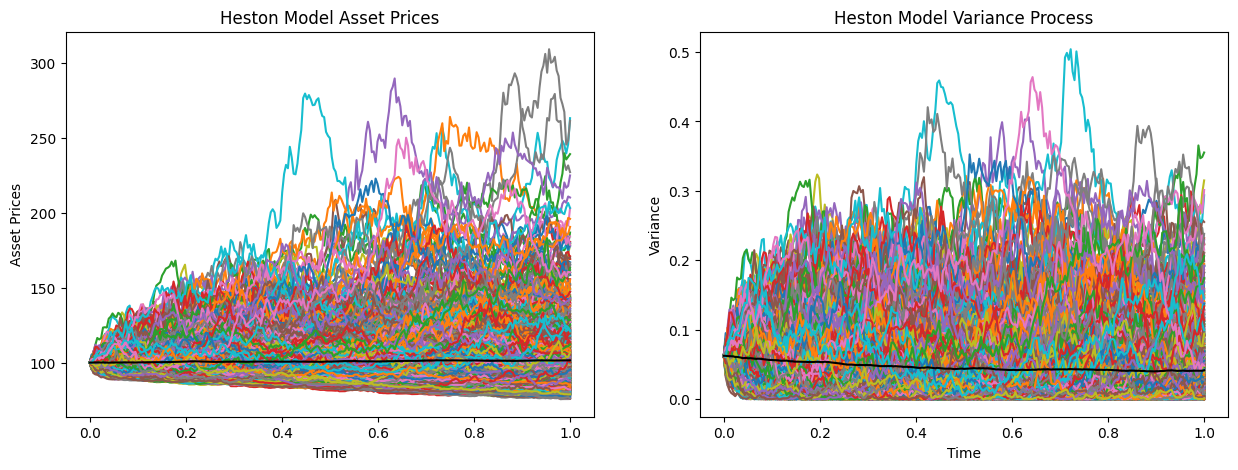

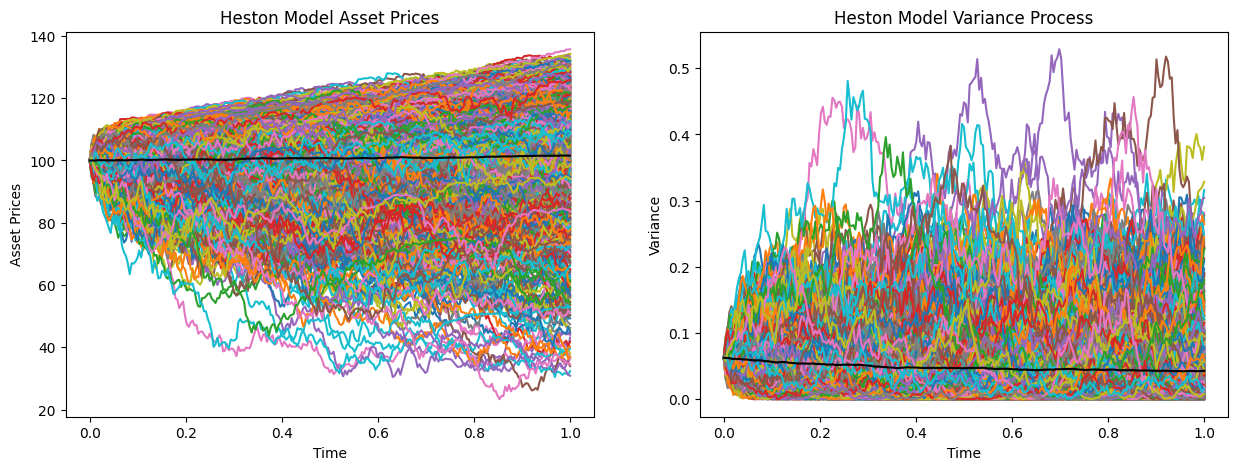

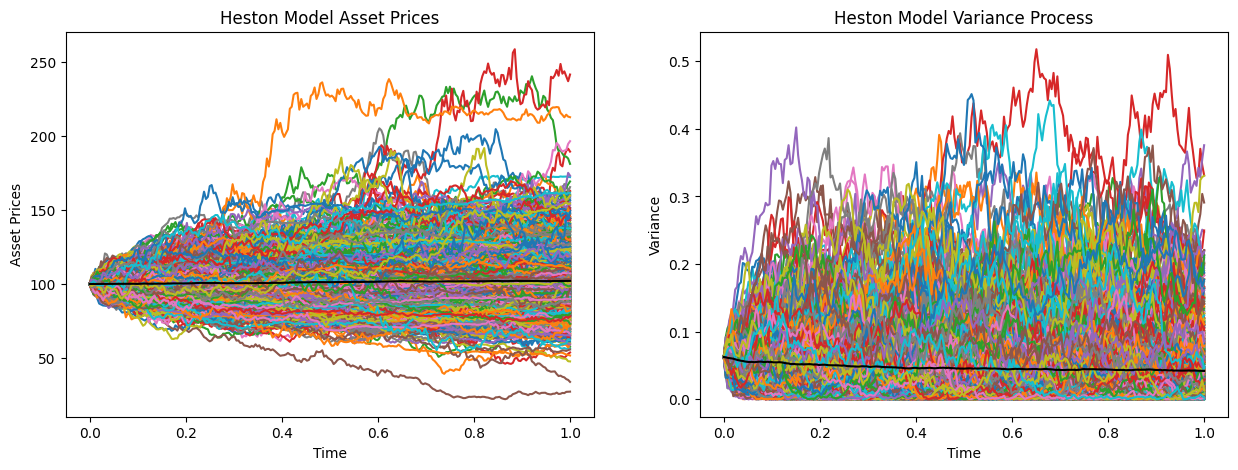

In [85]:
hm1 = HestonModelSim(S0 = 100.0, v0 = 0.25**2, rho =  0.98, kappa = 3, theta = 0.2**2, sigma = 0.6, T = 1.0, N = 252, M = 1000, r = 0.02)
hm2 = HestonModelSim(S0 = 100.0, v0 = 0.25**2, rho = -0.98, kappa = 3, theta = 0.2**2, sigma = 0.6, T = 1.0, N = 252, M = 1000, r = 0.02)
hm3 = HestonModelSim(S0 = 100.0, v0 = 0.25**2, rho = 0, kappa = 3, theta = 0.2**2, sigma = 0.6, T = 1.0, N = 252, M = 1000, r = 0.02)

hm1.run()
hm2.run()
hm3.run()
hm1.plot()
hm2.plot()
hm3.plot()

Here we can see how the correlation coefficient will affect our results on pricing. And also there is a way to do a tuning on Heston Parameters in a way that we can emulate GBM. We can visualy see that by the following:

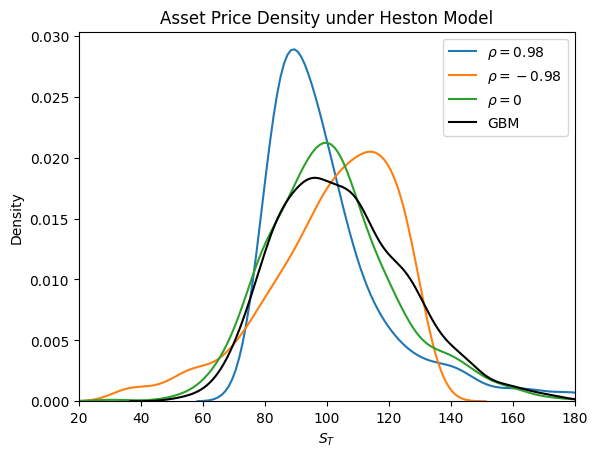

In [86]:
# simulate gbm process at time T

S0 = 100.0
v0 = 0.25**2
rho =  0.7
kappa = 3
theta = 0.2**2
sigma = 0.6 
T = 1.0 
N = 252 
M = 1000 
r = 0.02
gbm = S0*np.exp( (r - theta**2/2)*T + np.sqrt(theta)*np.sqrt(T)*np.random.normal(0,1,M) )

fig, ax = plt.subplots()

ax = sns.kdeplot(hm1.S[-1], label=r"$\rho= 0.98$", ax=ax)
ax = sns.kdeplot(hm2.S[-1], label=r"$\rho= -0.98$", ax=ax)
ax = sns.kdeplot(hm3.S[-1], label=r"$\rho= 0$", ax=ax)
ax = sns.kdeplot(gbm, label="GBM", ax=ax, color="Black")

plt.title(r'Asset Price Density under Heston Model')
plt.xlim([20, 180])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()

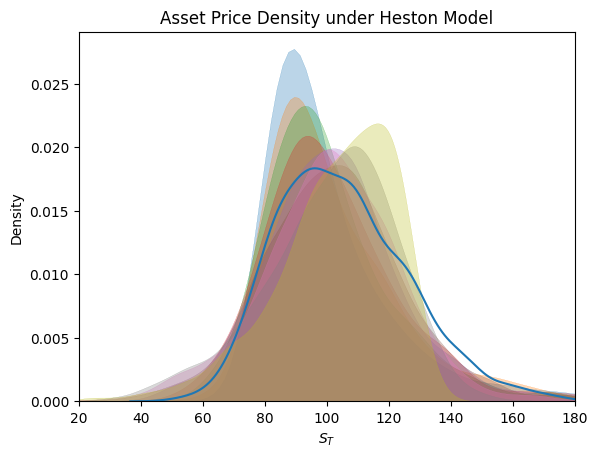

In [87]:
fig, ax = plt.subplots()
for i in np.linspace(0.98,-0.98,9):
    rho = round(i,2)
    hm = HestonModelSim(S0 = 100.0, v0 = 0.25**2, rho =  rho, kappa = 3, theta = 0.2**2, sigma = 0.6, T = 1.0, N = 252, M = 1000, r = 0.02)
    hm.run()
    # ax = sns.kdeplot(S[-1], label=r"$\rho= {rho}$", ax=ax)
    ax = sns.kdeplot(hm.S[-1], ax=ax,# multiple="stack",
   fill=True, common_norm=False, palette="crest", alpha=.3, linewidth=0.11)

ax = sns.kdeplot(gbm, label="GBM", ax=ax)
plt.title(r'Asset Price Density under Heston Model')
plt.xlim([20, 180])
plt.xlabel('$S_T$')
plt.ylabel('Density')
# plt.legend()
plt.show()

Just by changing $\rho$ there was possible to reach close to GBM distribution. But for a precise result, there is a way to full calibrate Heston Model in order to emulate GBM.


## Volatility Smile

In [93]:
hm.iv(opt_type="Call")

0.9953273329452987

ValueError: x and y must have same first dimension, but have shapes (80,) and (1,)

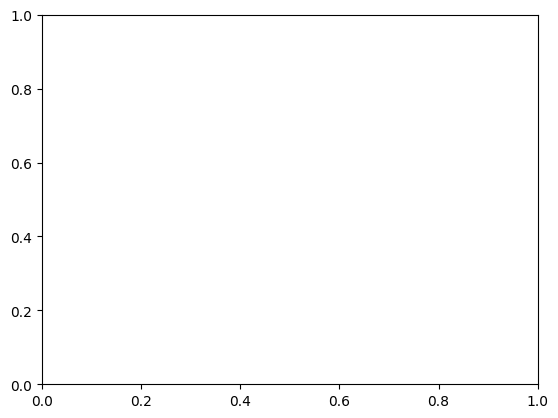

In [92]:
hm = HestonModelSim(S0 = 100.0, v0 = 0.25**2, rho = -0.7, kappa = 3, theta = 0.2**2, sigma = 0.6, T = 1.0, N = 252, M = 1000, r = 0.02)
hm.run()

plt.plot(hm.K, hm.iv(opt_type="Call"), label=r'IV calls')
plt.plot(hm.K, hm.iv(opt_type="Put"), label=r'IV puts')

plt.ylabel('Implied Volatility')
plt.xlabel('Strike')

plt.title('Implied Volatility Smile from Heston Model')
plt.legend()
plt.show()